## Making a model on predicting benign and malignant images using EfficientNetB7

## 1. Import Data and Display

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
from tensorflow.keras.metrics import Accuracy

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Link the all the training images and find its length
images = glob('train/*/*.jpg')
len(images)

210

## 2. Data Preprocessing

In [3]:
#replace backslash with forward slash to avoid unexpected errors during processing
images = [path.replace('\\', '/') for path in images]
# Make a dataframe(table) for the images' path
df = pd.DataFrame({'filepath': images})
# Use its folder name as the label to the images
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,train/benign/not_skin_cancer_00.jpg,benign
1,train/benign/not_skin_cancer_01.jpg,benign
2,train/benign/not_skin_cancer_04.jpg,benign
3,train/benign/not_skin_cancer_05.jpg,benign
4,train/benign/not_skin_cancer_06.jpg,benign


In [4]:
# Adding binary labels for classification
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,train/benign/not_skin_cancer_00.jpg,benign,0
1,train/benign/not_skin_cancer_01.jpg,benign,0
2,train/benign/not_skin_cancer_04.jpg,benign,0
3,train/benign/not_skin_cancer_05.jpg,benign,0
4,train/benign/not_skin_cancer_06.jpg,benign,0


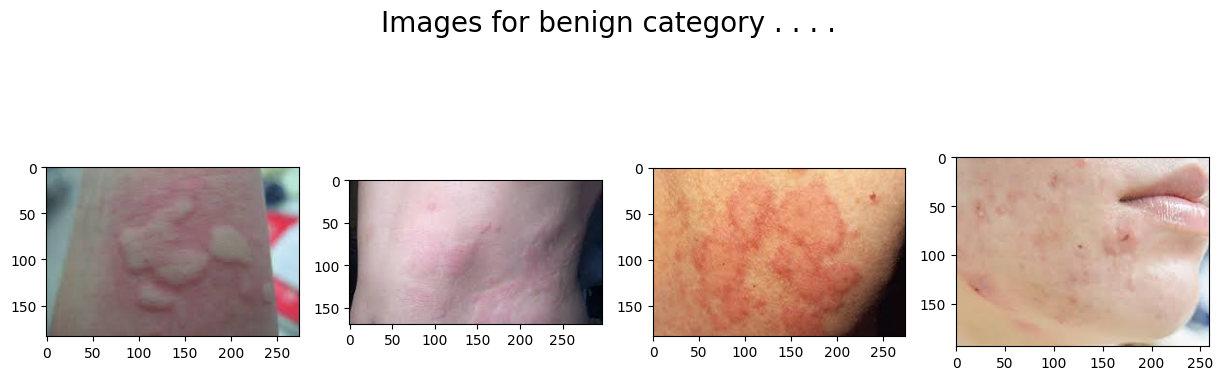

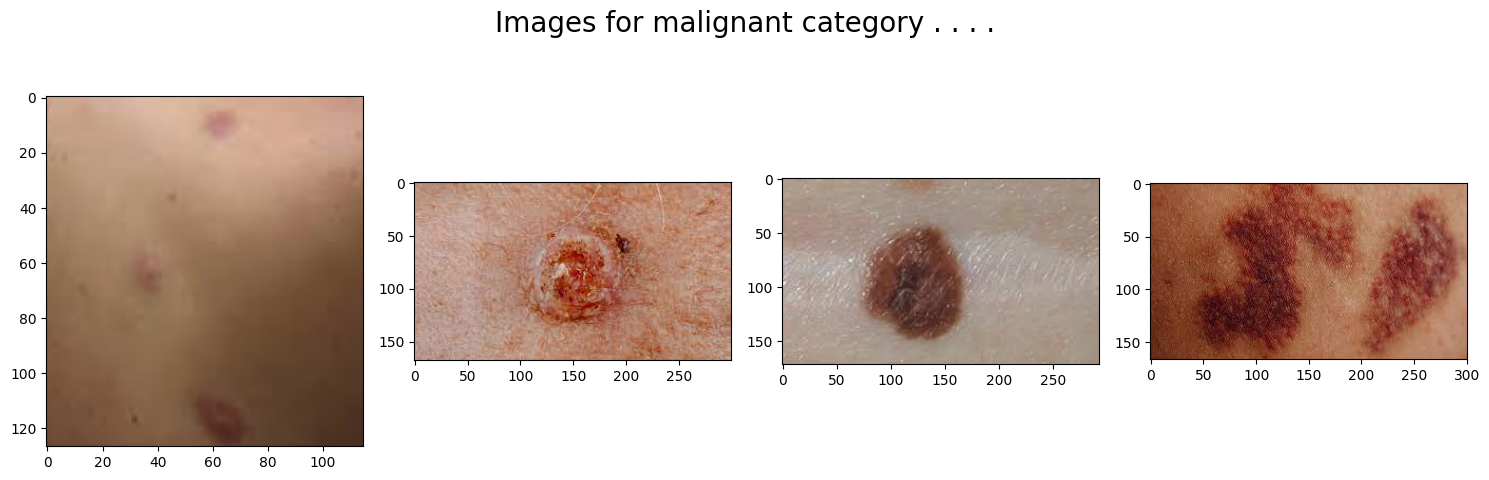

In [6]:
# Loop through the table column labels
for category in df['label'].unique():
    # Categorize the labels into two
	temp = df[df['label'] == category]
	index_list = temp.index
	# Make figure sizes into a certain size for display on two graphs
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	# Add titles for specific group graphs
	fig.suptitle(f'{category} images:', fontsize = 25)
	# Take 4 random images from their respective folders
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]
		image_path = data[0]
		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

## 2. Model Training

In [7]:
# Store the data into its respective training variables
features = df['filepath']
target = df['label_bin']
#
X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((178,), (32,))

In [8]:
#     return img, label
def decode_image(filepath, label=None):
    # Read image from file
    img = tf.io.read_file(filepath)
    
    # Decode JPEG-encoded image
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels
    
    # Resize image to desired dimensions
    img = tf.image.resize(img, [224, 224])
    
    # Normalize pixel values to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Convert label to integer if it's not already
    if label is not None:
        label = tf.cast(label, tf.int32)

    return img, label

In [9]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

In [10]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

In [11]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [12]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['accuracy', 'AUC']
)

In [13]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=20,
					verbose=1)

Epoch 1/20


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step - AUC: 0.7143 - accuracy: 0.6550 - loss: 0.6901 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 9.8112
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - AUC: 0.9169 - accuracy: 0.8532 - loss: 0.3744 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 11.2918
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - AUC: 0.9325 - accuracy: 0.8814 - loss: 0.3359 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 5.2177
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - AUC: 0.9484 - accuracy: 0.8650 - loss: 0.3045 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 6.3698
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - AUC: 0.9507 - accuracy: 0.8914 - loss: 0.2910 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 6.2988
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - AUC: 0.9720 - accuracy: 0.9098 - loss: 0.2334 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 4.3303
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step - AUC: 0.974

In [14]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
0,0.769027,0.702247,0.628614,0.500000,0.53125,9.811168
1,0.913700,0.831461,0.385482,0.500000,0.53125,11.291801
2,0.923697,0.865169,0.362744,0.533333,0.53125,5.217713
3,0.942789,0.859551,0.319144,0.500000,0.53125,6.369823
4,0.948529,0.870786,0.300011,0.500000,0.53125,6.298758


In [15]:
test_loss, test_acc, test_auc = model.evaluate(val_ds)
print('Test Accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - AUC: 0.9294 - accuracy: 0.8750 - loss: 0.3532
Test Accuracy: 0.875


In [16]:
model.save('model.h5')